In [1]:
## Approximate Q Learning for Stock Trend Prediction
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam



def make_nn(state_dim, num_hidden_layers, num_units):
    model = Sequential()
    model.add(Dense(num_units, input_dim = state_dim, activation='relu'))
    for i in range(num_hidden_layers-1):
        model.add(Dense(num_units, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam())
    return model

class NNQ:
    def __init__(self, mode, actions, states, epsilon, discount, num_layers = 3, num_units = 100):
        self.mode = mode  # train or test
        self.actions = actions  # list of actions
        self.states = states  # market history to walk through in the form of a 2D array
        self.epsilon = epsilon  # randomness of actions
        self.discount = discount  # discount factor
        self.nfeats = self.states.shape[-1]
        self.num_layers = num_layers
        self.num_units = num_units

        # initialize linear model w/ weights dictionary for each action
        self.models = dict([(a, make_nn(self.nfeats, self.num_layers, self.num_units)) for a in self.actions])

    def switch_mode(self, new_mode, new_states):
        self.mode = new_mode
        self.states = new_states

    def reset(self):
        '''
            - resets the weights of the agent (for repeated training and testing situations)
        '''
        self.models = dict([(a, make_nn(self.nfeats, self.num_layers, self.num_units)) for a in self.actions])

    def reward(self, a):
        '''
            - Calculates reward to give agent based on action a at timestep t in window w
            - Reward is based on regret
        '''

        if a == 'buy' or self.t == (len(self.states[self.w])-1):  # force agent to buy at end of time frame
            choice = self.states[self.w][self.t][-2] # difference in price from chosen day to initial day
            best = min([x[-2] for x in self.states[self.w]])  # best close price
            regret = choice - best
            return -choice, regret
        else:
            return 0, 0

    def value(self, s):
        return max(self.predict(a, s) for a in self.actions)

    def update(self, a, s, sp, r):
        '''
            - Takes in action a, state s, next state sp, and reward r
            - Training on your network for action a, on a data set made up of a single data point, where the input is
            - s and the desired output is t
        '''
        t = r + self.discount * self.value(sp)
        X = np.array(s).reshape(1,self.nfeats)
        Y = np.array(t)
        self.models[a].fit(X, Y, epochs=1, verbose=0)

    def predict(self, a, s):
        '''
            - Takes in action a and state s
            - Performs function approximation to predict q-value
            - Returns q-value prediction
        '''

        return self.models[a].predict(np.array(s).reshape(1, self.nfeats))


    def epsilon_greedy(self, s, eps=0.5):
        '''
            - Takes in state and epsilon and returns action
        '''
        if self.mode == 'test':
            eps = 0

        if random.random() < eps:  # True with prob eps, random action
            return self.actions[random.randint(0,len(self.actions)-1)]
        else:  # False with prob 1-eps, greedy action
            q_vals = np.zeros(len(self.actions))
            for i, a in enumerate(self.actions):

                q_vals[i] = self.predict(a, s)

            return self.actions[q_vals.argmax()]

    def transition(self, a):
        '''
            - Takes in t, w and returns next state
        '''

        self.t += 1  # move to next day
        if self.t == len(self.states[self.w]) or a == 'buy':
            self.t = 0
            self.w += 1
            if self.w == len(self.states):
                return None  # We are finished traversing state space

        return tuple(self.states[self.w][self.t])  # return next state



    def learn(self, iters=100):
        '''
            - Takes in state and epsilon and returns action
        '''
        self.w = 0  # window index
        self.t = 0  # timestep index within window
        s = tuple(self.states[self.w][self.t])  # init state
        actions = []
        profit = []
        regret = []
        for _ in range(iters):
            a = self.epsilon_greedy(s, self.epsilon)
            actions.append(a)

            r, reg = self.reward(a)
            if a == 'buy':
                profit.append(r)
                regret.append(reg)

            s_prime = self.transition(a)

            if s_prime is None:
                break

            if self.mode == 'train':
                self.update(a, s, s_prime, r)

            s = s_prime

        return actions, profit, regret

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
import sys
sys.path.append('..')
from utils import gen_states, evaluate_agent_advanced
from collections import Counter
import numpy as np



def evaluate(title, actions, profit, regret):
    ac = Counter(actions)
    purch = ac['buy'] / len(actions)

#     print('{} purchase fraction: {:.4f}'.format(title, purch))
#     print('{} avg. profit: {:.4f}'.format(title, np.mean(profit)))
#     print('{} avg. regret: {:.4f}'.format(title, np.mean(regret)))
    return np.mean(profit), np.mean(regret)

## Initialize Parameters
window_size = 5
history_size = 3
train, val, test = gen_states('Apple_cleaned.csv', window_size, history_size)
actions = ['buy', 'wait']
epsilon = .05
discount = 1
num_layers = np.linspace(start=1,stop=19,num=10)
num_units = np.linspace(start=1,stop=10,num=10)


## Pass to Approximate Q-Learning Agent
profits = []
regrets = []
pairs = []
for layer in num_layers:
    for unit in num_units:
        agent = NNQ('train', actions, train, epsilon, discount, int(layer), int(unit))
        agent.switch_mode('val', val)
        val_actions, val_profit, val_regret = agent.learn()
        profit, regret = evaluate('val', val_actions, val_profit, val_regret)
        profits.append(profit)
        regrets.append(regret)
        pairs.append((layer, unit))
        print((layer, unit))




(1.0, 1.0)
(1.0, 2.0)
(1.0, 3.0)
(1.0, 4.0)
(1.0, 5.0)
(1.0, 6.0)
(1.0, 7.0)
(1.0, 8.0)
(1.0, 9.0)
(1.0, 10.0)
(3.0, 1.0)
(3.0, 2.0)
(3.0, 3.0)
(3.0, 4.0)
(3.0, 5.0)
(3.0, 6.0)
(3.0, 7.0)
(3.0, 8.0)
(3.0, 9.0)
(3.0, 10.0)
(5.0, 1.0)
(5.0, 2.0)
(5.0, 3.0)
(5.0, 4.0)
(5.0, 5.0)
(5.0, 6.0)
(5.0, 7.0)
(5.0, 8.0)
(5.0, 9.0)
(5.0, 10.0)
(7.0, 1.0)
(7.0, 2.0)
(7.0, 3.0)
(7.0, 4.0)
(7.0, 5.0)
(7.0, 6.0)
(7.0, 7.0)
(7.0, 8.0)
(7.0, 9.0)
(7.0, 10.0)
(9.0, 1.0)
(9.0, 2.0)
(9.0, 3.0)
(9.0, 4.0)
(9.0, 5.0)
(9.0, 6.0)
(9.0, 7.0)
(9.0, 8.0)
(9.0, 9.0)
(9.0, 10.0)
(11.0, 1.0)
(11.0, 2.0)
(11.0, 3.0)
(11.0, 4.0)
(11.0, 5.0)
(11.0, 6.0)
(11.0, 7.0)
(11.0, 8.0)
(11.0, 9.0)
(11.0, 10.0)
(13.0, 1.0)
(13.0, 2.0)
(13.0, 3.0)
(13.0, 4.0)
(13.0, 5.0)
(13.0, 6.0)
(13.0, 7.0)
(13.0, 8.0)
(13.0, 9.0)
(13.0, 10.0)
(15.0, 1.0)
(15.0, 2.0)
(15.0, 3.0)
(15.0, 4.0)
(15.0, 5.0)
(15.0, 6.0)
(15.0, 7.0)
(15.0, 8.0)
(15.0, 9.0)
(15.0, 10.0)
(17.0, 1.0)
(17.0, 2.0)
(17.0, 3.0)
(17.0, 4.0)
(17.0, 5.0)
(17.0, 6.0)
(17.0, 7.0

In [26]:
pairs[np.argmin(np.array(regrets))]

(15.0, 9.0)

In [27]:
np.array(regrets)

array([1.15083458, 0.3550005 , 1.22054141, 1.19574536, 1.3915013 ,
       2.0649985 , 1.57742903, 1.45586266, 1.4130013 , 1.18828663,
       1.29185796, 1.21953537, 1.30958437, 1.11754728, 1.515626  ,
       1.14666733, 2.419998  , 1.51058971, 1.25660074, 1.28280044,
       1.3147153 , 1.29471506, 1.30314369, 1.16942927, 1.09884637,
       0.9900009 , 1.27200084, 1.29185796, 1.20833414, 1.26757194,
       1.28300067, 1.185625  , 1.29457229, 0.81000033, 1.28085821,
       1.63807715, 1.64205935, 1.3883345 , 1.1968755 , 1.27600091,
       1.28328654, 1.29071507, 1.03928612, 1.27728644, 1.12891957,
       2.07      , 1.22014371, 1.3637505 , 1.52444456, 1.34595317,
       1.31185799, 1.29071507, 1.26014366, 1.20042937, 1.26085786,
       2.2800002 , 1.04650873, 1.17100084, 1.24933343, 1.47166717,
       1.33357221, 1.28885807, 1.3010008 , 0.136668  , 0.510002  ,
       1.229738  , 1.290001  , 1.29614371, 1.12878107, 0.6675015 ,
       1.27757213, 1.27185794, 1.29314373, 1.31371507, 1.32514

In [31]:
import matplotlib.pyplot as plt



In [36]:
len(regrets)

100

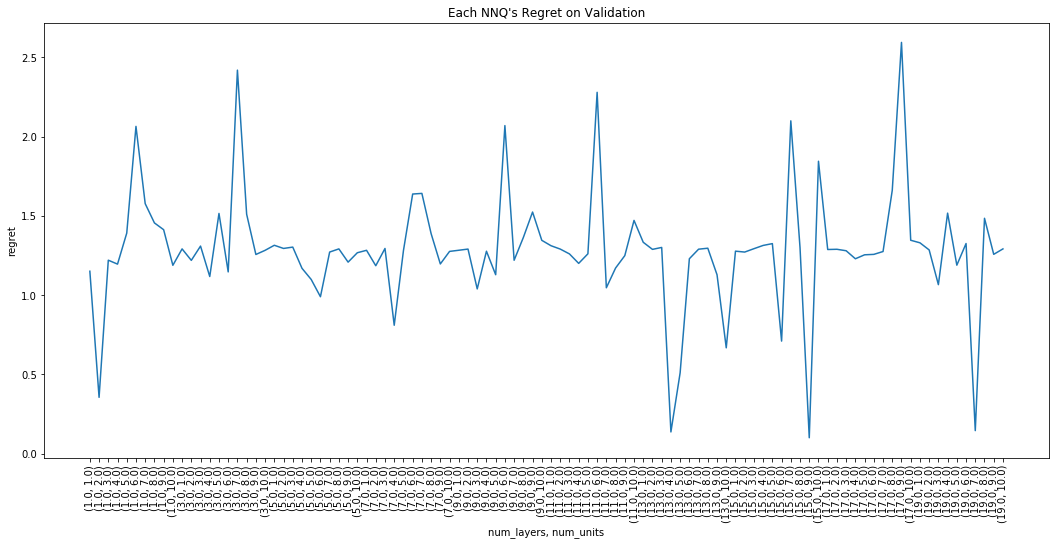

In [47]:
x = np.linspace(start=1,stop = 100, num=100)
y=regrets
plt.figure(figsize=(18,8))
plt.plot(x,y)
plt.xticks(x, pairs, rotation='vertical')
plt.xlabel('num_layers, num_units')
plt.ylabel('regret')
plt.title("Each NNQ's Regret on Validation")
plt.savefig('tuning.jpg')